# Thinking in tensors, writing in PyTorch

A hands-on course by [Piotr Migdał](https://p.migdal.pl) (2019).

<a href="https://colab.research.google.com/github/stared/thinking-in-tensors-writing-in-pytorch/blob/master/5%20Nonlinear%20regression.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>

## Notebook 5: Non-linear regression

Very **Work in Progress**

![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Correlation_examples2.svg/400px-Correlation_examples2.svg.png)


### Exercise

Which of the following can be described by linear regression:

* without any modifications,
* by after rescaling *x* or *y*,
* cannot be described by linear regression?

**TODO**

* Prepare examples
* 1d function with nonlinearities (by hand and automatically)
* More advanced

**Datasets to consider**

* https://en.wikipedia.org/wiki/Flight_airspeed_record

**TODO later**

* livelossplot `plot_extrema` error
* drawing a plot 
* consider using [hiddenlayer](https://github.com/waleedka/hiddenlayer)

In [2]:
!pip install livelossplot

In [3]:
%matplotlib inline

from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import tensor
from livelossplot import PlotLosses

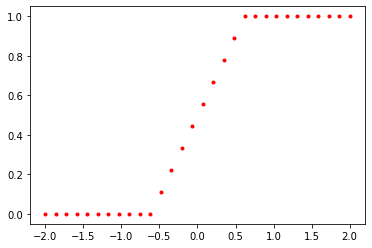

In [4]:
X = torch.linspace(-2., 2., 30).unsqueeze(1)
Y = torch.cat([torch.zeros(10),  torch.linspace(0., 1., 10), 1. + torch.zeros(10)], dim=0)
plt.plot(X.squeeze().numpy(), Y.numpy(), 'r.')

In [5]:
linear_model = nn.Linear(in_features=1, out_features=1)

In [6]:
def train(X, Y, model, loss_function, optim, num_epochs):
    loss_history = []
    
    def extra_plot(*args):
        plt.plot(X.squeeze(1).numpy(), Y.numpy(), 'r.', label="Ground truth")
        plt.plot(X.squeeze(1).numpy(), model(X).detach().numpy(), '-', label="Model")
        plt.title("Prediction")
        plt.legend(loc='lower right')
    
    liveloss = PlotLosses(extra_plots=[extra_plot], plot_extrema=False)

    for epoch in range(num_epochs):
        
        epoch_loss = 0.0
        
        Y_pred = model(X)
        loss = loss_function(Y_pred, Y)
        
        loss.backward()
        optim.step()
        optim.zero_grad()
        
        liveloss.update({
            'loss': loss.data.item(),
        })
        liveloss.draw()

## Linear model

$$y = a x + b$$

In [7]:
class Linear(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer_weights = nn.Parameter(torch.randn(1, 1))
        self.layer_bias = nn.Parameter(torch.randn(1))
        
    def forward(self, x):
        return x.matmul(self.layer_weights).add(self.layer_bias).squeeze()

In [8]:
linear_model = Linear()
optim = torch.optim.SGD(linear_model.parameters(), lr=0.03)
loss_function = nn.MSELoss()

In [9]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.3353]], requires_grad=True), Parameter containing:
 tensor([-0.5386], requires_grad=True)]

In [10]:
linear_model(X)

tensor([-1.2091, -1.1629, -1.1166, -1.0704, -1.0241, -0.9779, -0.9317, -0.8854,
        -0.8392, -0.7929, -0.7467, -0.7004, -0.6542, -0.6080, -0.5617, -0.5155,
        -0.4692, -0.4230, -0.3768, -0.3305, -0.2843, -0.2380, -0.1918, -0.1456,
        -0.0993, -0.0531, -0.0068,  0.0394,  0.0857,  0.1319],
       grad_fn=<SqueezeBackward0>)

In [11]:
train(X, Y, linear_model, loss_function, optim, num_epochs=50)

TypeError: ignored

## Nonlinear

$$ x \mapsto h \mapsto y$$

In [12]:
class Nonlinear(nn.Module):
    def __init__(self, hidden_size=2):
        super().__init__()
        
        self.layer_1_weights = nn.Parameter(torch.randn(1, hidden_size))
        self.layer_1_bias = nn.Parameter(torch.randn(hidden_size)) 
        
        self.layer_2_weights = nn.Parameter(torch.randn(hidden_size, 1) ) 
        self.layer_2_bias = nn.Parameter(torch.randn(1))
        
    def forward(self, x):
        x = x.matmul(self.layer_1_weights).add(self.layer_1_bias)
        x = x.relu()
        x = x.matmul(self.layer_2_weights).add(self.layer_2_bias)
        return x.squeeze()
    
    def nonrandom_init(self):
        self.layer_1_weights.data = tensor([[1.1, 0.8]])
        self.layer_1_bias.data = tensor([0.5 , -0.7]) 
        self.layer_2_weights.data = tensor([[0.3], [-0.7]])
        self.layer_2_bias.data = tensor([0.2])

In [13]:
nonlinear_model = Nonlinear(hidden_size=2)
nonlinear_model.nonrandom_init()

optim = torch.optim.SGD(nonlinear_model.parameters(), lr=0.2)
# optim = torch.optim.Adam(nonlinear_model.parameters(), lr=0.1)
loss_function = nn.MSELoss()

In [14]:
train(X, Y, nonlinear_model, loss_function, optim, num_epochs=200)

TypeError: ignored

## Other shapes and activations

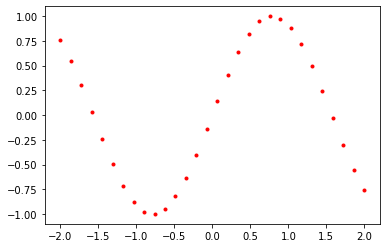

In [15]:
Y_sin = (2 * X).sin()
plt.plot(X.squeeze().numpy(), Y_sin.numpy(), 'r.')

In [16]:
# warning: 
# for 1-d problems it rarely works (often gets stuck in some local minimum)
nonlinear_model = Nonlinear(hidden_size=10)

optim = torch.optim.Adam(nonlinear_model.parameters(), lr=0.01)
loss_function = nn.MSELoss()
train(X, Y_sin, nonlinear_model, loss_function, optim, num_epochs=100)

TypeError: ignored

In [17]:
class NonlinearSigmoid2(nn.Module):
    def __init__(self, hidden_size=2):
        super().__init__()
        
        self.layer_1_weights = nn.Parameter(torch.randn(1, hidden_size))
        self.layer_1_bias = nn.Parameter(torch.randn(hidden_size))
        
        self.layer_2_weights = nn.Parameter(torch.randn(hidden_size, 1))
        self.layer_2_bias = nn.Parameter(torch.randn(1))
        
    def forward(self, x):
        x = x.matmul(self.layer_1_weights).add(self.layer_1_bias)
        x = x.sigmoid()
        x = x.matmul(self.layer_2_weights).add(self.layer_2_bias)
        x = x.sigmoid()
        return x.squeeze()

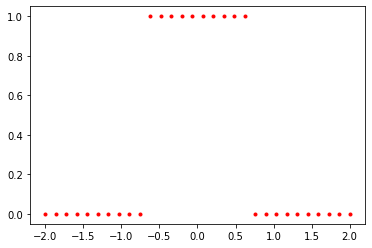

In [18]:
X1 = torch.linspace(-2., 2., 30).unsqueeze(1)
Y1 = torch.cat([torch.zeros(10), 1. + torch.zeros(10),  torch.zeros(10)], dim=0)
plt.plot(X1.squeeze().numpy(), Y1.numpy(), 'r.')

In [19]:
nonlinear_model = NonlinearSigmoid2(hidden_size=2)
# optim = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)
optim = torch.optim.Adam(nonlinear_model.parameters(), lr=0.1)
loss_function = nn.MSELoss()
train(X1, Y1, nonlinear_model, loss_function, optim, num_epochs=100)

TypeError: ignored

## Nonlinear model - by hand

In [20]:
my_nonlinear_model = Nonlinear(hidden_size=2)

In [21]:
my_nonlinear_model.layer_1_weights.data = tensor([[1. , 1.]])
my_nonlinear_model.layer_1_bias.data = tensor([1. , -1.])

In [23]:
X.matmul(my_nonlinear_model.layer_1_weights).add(my_nonlinear_model.layer_1_bias).relu()

tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.1034, 0.0000],
        [0.2414, 0.0000],
        [0.3793, 0.0000],
        [0.5172, 0.0000],
        [0.6552, 0.0000],
        [0.7931, 0.0000],
        [0.9310, 0.0000],
        [1.0690, 0.0000],
        [1.2069, 0.0000],
        [1.3448, 0.0000],
        [1.4828, 0.0000],
        [1.6207, 0.0000],
        [1.7586, 0.0000],
        [1.8966, 0.0000],
        [2.0345, 0.0345],
        [2.1724, 0.1724],
        [2.3103, 0.3103],
        [2.4483, 0.4483],
        [2.5862, 0.5862],
        [2.7241, 0.7241],
        [2.8621, 0.8621],
        [3.0000, 1.0000]], grad_fn=<ReluBackward0>)

In [25]:
my_nonlinear_model.layer_2_weights.data = tensor([[0.5], [-0.5]])
my_nonlinear_model.layer_2_bias.data = tensor([0.])

In [26]:
my_nonlinear_model(X)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0517,
        0.1207, 0.1897, 0.2586, 0.3276, 0.3966, 0.4655, 0.5345, 0.6034, 0.6724,
        0.7414, 0.8103, 0.8793, 0.9483, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000], grad_fn=<SqueezeBackward0>)

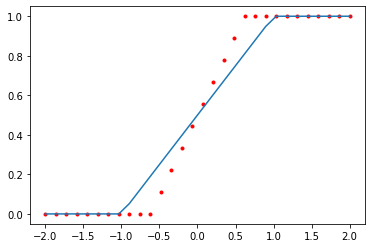

In [27]:
plt.plot(X.squeeze(1).numpy(), Y.numpy(), 'r.')
plt.plot(X.squeeze(1).numpy(), my_nonlinear_model(X).detach().numpy(), '-')